<a href="https://colab.research.google.com/github/seunghoonss/AI-HACKATHON/blob/main/golf%20skeleton%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!pip install imshow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for imshow: filename=imshow-0.0.3-py3-none-any.whl size=2463 sha256=71b19b20b161c7d94f4b60d9f08f04b1480e12e5179b7322add80b00c2273e66
  Stored in directory: /root/.cache/pip/wheels/c2/c7/3c/69c0f9e7241ea01ec47a72be6406f42c4dece8198f9f483f0f
Successfully built imshow


In [3]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 31.7 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 23.1.4 which is incompatible.


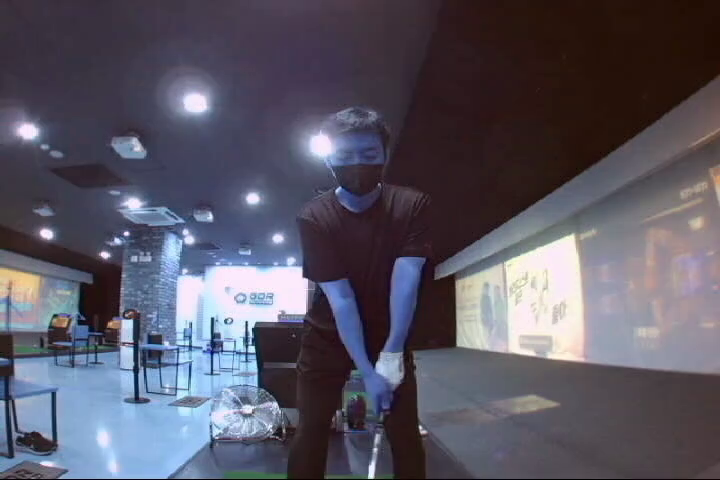

In [17]:
from google.colab.patches import cv2_imshow
cv2_imshow(img)

In [22]:
import matplotlib.pyplot as plt
import cv2
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

    return plt.imshow(a, **kwargs)

In [29]:
import cv2
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

video_path = '/content/gdrive/MyDrive/golf/01.mp4'
cap = cv2.VideoCapture(video_path)

fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
out = cv2.VideoWriter('%s_output.mp4' % (video_path.split('.')[0]), fourcc, cap.get(cv2.CAP_PROP_FPS), (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))))

pose = mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
    model_complexity=2)

is_first = True # 어드레스 시 첫 프레임을 받아오기 위한 플래그
# 어드레스 시 첫 프레임의 좌표를 저장할 변수
first_center_x, first_center_y, first_radius = None, None, None

while cap.isOpened():
    ret, img = cap.read()
    if not ret:
        break

    img_h, img_w, _ = img.shape

    img_result = img.copy()

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = pose.process(img)

    mp_drawing.draw_landmarks(
        img_result,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())

    if results.pose_landmarks:
        # https://google.github.io/mediapipe/solutions/pose.html#pose-landmark-model-blazepose-ghum-3d
        landmark = results.pose_landmarks.landmark

        left_ear_x = landmark[mp_pose.PoseLandmark.LEFT_EAR].x * img_w
        left_ear_y = landmark[mp_pose.PoseLandmark.LEFT_EAR].y * img_h

        right_ear_x = landmark[mp_pose.PoseLandmark.RIGHT_EAR].x * img_w
        right_ear_y = landmark[mp_pose.PoseLandmark.RIGHT_EAR].y * img_h

        center_x = int((left_ear_x + right_ear_x) / 2)
        center_y = int((left_ear_y + right_ear_y) / 2)

        radius = int((left_ear_x - right_ear_x) / 2)
        radius = max(radius, 20)

        if is_first: # 어드레스 시 첫 프레임의 머리 좌표 저장
            first_center_x = center_x
            first_center_y = center_y
            first_radius = int(radius * 2)

            is_first = False
        else:
            cv2.circle(img_result, center=(first_center_x, first_center_y),
                radius=first_radius, color=(0, 255, 255), thickness=2)

            color = (0, 255, 0) # 초록색

            # 머리가 원래 위치보다 많이 벗어난 경우
            if center_x - radius < first_center_x - first_radius \
                or center_x + radius > first_center_x + first_radius:
                color = (0, 0, 255) # 빨간색

            cv2.circle(img_result, center=(center_x, center_y),
                radius=radius, color=color, thickness=2)
    
    from google.colab.patches import cv2_imshow
    
    #cv2_imshow(cv2.resize(img_result, (800, 600)))
    #cv2.imshow('AI Golf Coach', img_result)
    
    import matplotlib.pyplot as plt
    import cv2
    def cv2_imshow(a, **kwargs):
        a = a.clip(0, 255).astype('uint8')
        # cv2 stores colors as BGR; convert to RGB
        if a.ndim == 3:
            if a.shape[2] == 4:
                a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
            else:
                a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)

        return plt.imshow(a, **kwargs)
    out.write(img_result)

    if cv2.waitKey(1) == ord('q'):
        break


    
pose.close()
cap.release()
out.release()